In [1]:
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import zipfile

In [2]:
# Descargar y descomprimir dataset
!gdown 1KPZtyey0H-q3fzDnHXO0qboEryu_eRCw -O ../Dataset_emocional.zip

zip_path = "../Dataset_emocional.zip"
extract_path = ".."

# Descomprimir
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
    print(f"Descomprimido en: {extract_path}")


Downloading...
From (original): https://drive.google.com/uc?id=1KPZtyey0H-q3fzDnHXO0qboEryu_eRCw
From (redirected): https://drive.google.com/uc?id=1KPZtyey0H-q3fzDnHXO0qboEryu_eRCw&confirm=t&uuid=c65277bc-98c0-4af9-b897-0f6afb1d5db0
To: c:\Users\cance\Documents\GitHub\Sentimental_emoji_classifier\Dataset_emocional.zip

  0%|          | 0.00/55.3M [00:00<?, ?B/s]
  1%|          | 524k/55.3M [00:00<01:44, 524kB/s]
  2%|▏         | 1.05M/55.3M [00:01<00:59, 914kB/s]
  3%|▎         | 1.57M/55.3M [00:01<00:39, 1.37MB/s]
  5%|▍         | 2.62M/55.3M [00:01<00:21, 2.51MB/s]
  7%|▋         | 3.67M/55.3M [00:01<00:13, 3.78MB/s]
  9%|▉         | 5.24M/55.3M [00:01<00:08, 5.67MB/s]
 12%|█▏        | 6.82M/55.3M [00:01<00:06, 7.21MB/s]
 14%|█▍        | 7.86M/55.3M [00:02<00:06, 7.72MB/s]
 17%|█▋        | 9.44M/55.3M [00:02<00:05, 8.88MB/s]
 20%|█▉        | 11.0M/55.3M [00:02<00:04, 9.72MB/s]
 23%|██▎       | 12.6M/55.3M [00:02<00:04, 10.3MB/s]
 26%|██▌       | 14.2M/55.3M [00:02<00:03, 10.7MB/s]
 2

Descomprimido en: ..


In [61]:
# Cargar dataset
base_images_dir = Path("../Dataset_emocional")

# Crear datasets
ORIGINAL_IMG_SIZE = (28, 28)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    str(base_images_dir),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=ORIGINAL_IMG_SIZE,
    batch_size=batch_size,
    color_mode='grayscale'
)

val_ds = keras.utils.image_dataset_from_directory(
    str(base_images_dir),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=ORIGINAL_IMG_SIZE,
    batch_size=batch_size,
    color_mode='grayscale'
)

class_names = train_ds.class_names
num_classes = len(class_names)

print(f"Clases: {class_names}")
print(f"Número de clases: {num_classes}")

# Optimizar datasets
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 812 files belonging to 3 classes.
Using 650 files for training.
Using 650 files for training.
Found 812 files belonging to 3 classes.
Using 162 files for validation.
Found 812 files belonging to 3 classes.
Using 162 files for validation.
Clases: ['Enojado', 'Feliz', 'Triste']
Número de clases: 3
Clases: ['Enojado', 'Feliz', 'Triste']
Número de clases: 3


In [62]:
# Normalizar datos
train_ds_normalized = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds_normalized = val_ds.map(lambda x, y: (x / 255.0, y))

print("Datasets normalizados")

Datasets normalizados


In [83]:
# Construir CNN desde cero
cnn_model = models.Sequential([
    # Capa convolucional 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    # Capa convolucional 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    # Capa convolucional 3
    layers.Conv2D(64, (3, 3), activation='relu'),
    
    # Capas densas
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

print("Modelo CNN creado")
cnn_model.summary()

Modelo CNN creado


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_51 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,987 (507.76 KB)

 Trainable params: 129,987 (507.76 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
# Compilar modelo
cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Modelo compilado")

Modelo compilado


In [85]:
# Entrenar modelo
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

epochs = 80

history = cnn_model.fit(
    train_ds_normalized,
    validation_data=val_ds_normalized,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=1
)

print("\nEntrenamiento completado")

Epoch 1/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3354 - loss: 1.1157 - val_accuracy: 0.4383 - val_loss: 1.0996
Epoch 2/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3354 - loss: 1.1157 - val_accuracy: 0.4383 - val_loss: 1.0996
Epoch 2/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4185 - loss: 1.0819 - val_accuracy: 0.4383 - val_loss: 1.0954
Epoch 3/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4185 - loss: 1.0819 - val_accuracy: 0.4383 - val_loss: 1.0954
Epoch 3/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4123 - loss: 1.0849 - val_accuracy: 0.4383 - val_loss: 1.0897
Epoch 4/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4123 - loss: 1.0849 - val_accuracy: 0.4383 - val_loss: 1.0897
Epoch 4/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4062 - loss: 1.0780 - val_accuracy: 0.4383 - val_loss: 1.0868
Epoch 5/80
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4062 - loss: 1.0780 - val_accuracy: 0.4383 - val

In [89]:
# Guardar modelo
cnn_model.save("cnn_model_emociones_v2.h5")
print("Modelo guardado como 'cnn_model_emociones.h5'")

Modelo guardado como 'cnn_model_emociones.h5'


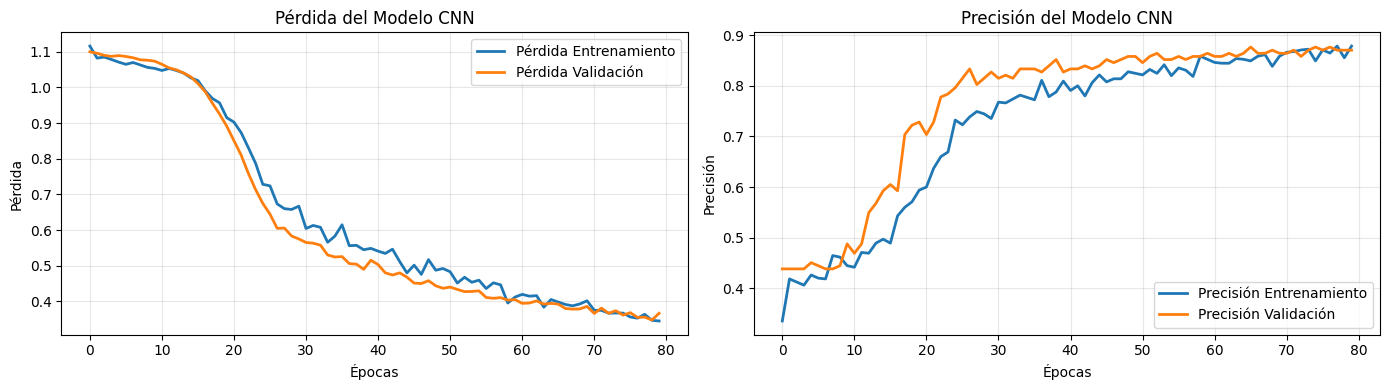

Épocas entrenadas: 80
Precisión final validación: 0.8704


In [86]:
# Gráficos de entrenamiento
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss
axes[0].plot(history.history['loss'], label='Pérdida Entrenamiento', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Pérdida Validación', linewidth=2)
axes[0].set_xlabel('Épocas')
axes[0].set_ylabel('Pérdida')
axes[0].set_title('Pérdida del Modelo CNN')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Precisión Entrenamiento', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Precisión Validación', linewidth=2)
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Precisión')
axes[1].set_title('Precisión del Modelo CNN')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Épocas entrenadas: {len(history.history['loss'])}")
print(f"Precisión final validación: {history.history['val_accuracy'][-1]:.4f}")

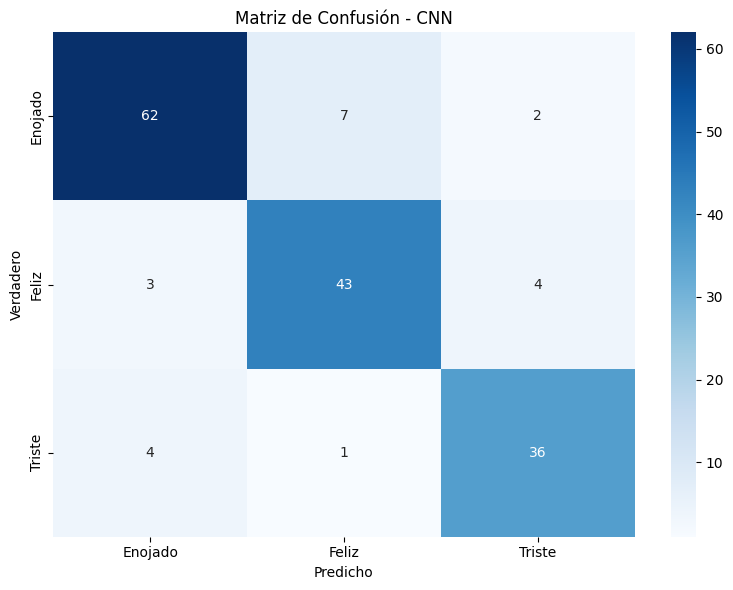


Reporte de Clasificación:
              precision    recall  f1-score   support

     Enojado       0.90      0.87      0.89        71
       Feliz       0.84      0.86      0.85        50
      Triste       0.86      0.88      0.87        41

    accuracy                           0.87       162
   macro avg       0.87      0.87      0.87       162
weighted avg       0.87      0.87      0.87       162



In [87]:
# Evaluar en validación
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_true = []
y_pred = []

for x_batch, y_batch in val_ds_normalized:
    predictions = cnn_model.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(y_batch.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - CNN')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [88]:
# Métricas globales
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("="*50)
print("MÉTRICAS GLOBALES DEL MODELO CNN")
print("="*50)
print(f"Accuracy (Precisión General):  {accuracy:.4f}  ({accuracy*100:.2f}%)")
print(f"Precision (Ponderada):         {precision:.4f}  ({precision*100:.2f}%)")
print(f"Recall (Sensibilidad):         {recall:.4f}  ({recall*100:.2f}%)")
print(f"F1 Score (Balance):            {f1:.4f}")
print("="*50)



MÉTRICAS GLOBALES DEL MODELO CNN
Accuracy (Precisión General):  0.8704  (87.04%)
Precision (Ponderada):         0.8710  (87.10%)
Recall (Sensibilidad):         0.8704  (87.04%)
F1 Score (Balance):            0.8705


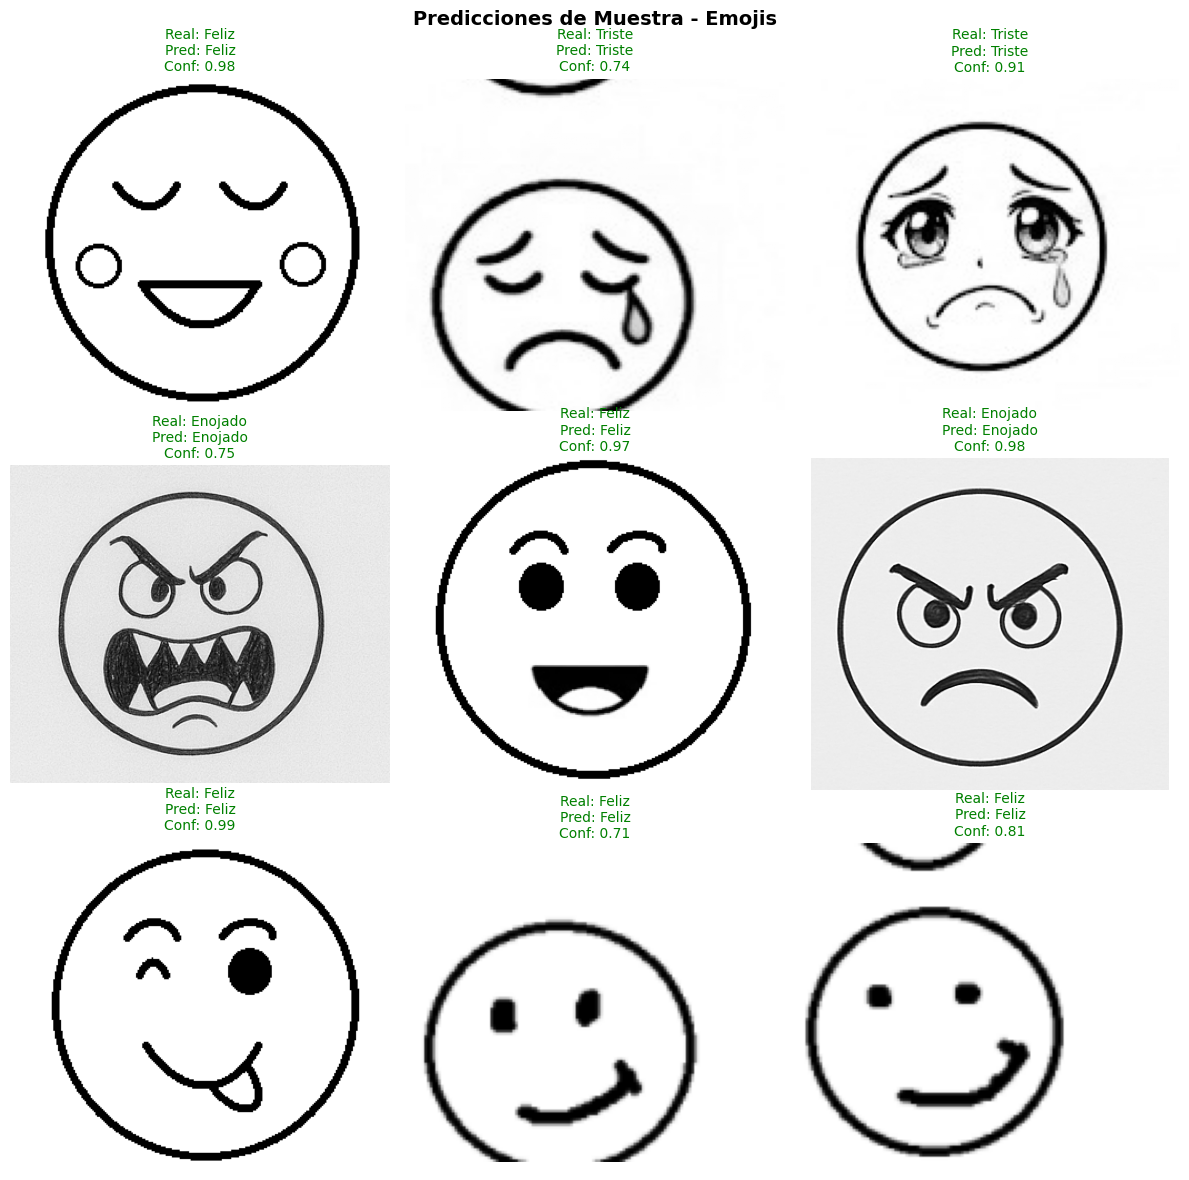

In [94]:
# Predicciones de muestra con imágenes originales
import random
import cv2
import os

# Obtener rutas de imágenes de validación
base_dir = Path("../Dataset_emocional")
all_images = []

for class_idx, class_name in enumerate(class_names):
    class_dir = base_dir / class_name
    for img_file in os.listdir(class_dir):
        if img_file.endswith(('.png', '.jpg', '.jpeg')):
            all_images.append({
                'path': class_dir / img_file,
                'label': class_idx,
                'class_name': class_name
            })

# Seleccionar 9 imágenes aleatorias
sample = random.sample(all_images, 9)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Predicciones de Muestra - Emojis', fontsize=14, fontweight='bold')

for i, img_info in enumerate(sample):
    ax = axes[i // 3, i % 3]
    
    # Cargar imagen original (alta resolución)
    img_original = cv2.imread(str(img_info['path']), cv2.IMREAD_GRAYSCALE)
    true_label = img_info['label']
    
    # Redimensionar solo para predicción
    img_resized = cv2.resize(img_original, (28, 28))
    img_normalized = img_resized.astype('float32') / 255.0
    
    # Predicción
    pred = cnn_model.predict(img_normalized.reshape(1, 28, 28, 1), verbose=0)
    pred_label = np.argmax(pred)
    confidence = pred[0][pred_label]
    
    # Mostrar imagen ORIGINAL (alta resolución)
    ax.imshow(img_original, cmap='gray')
    ax.axis('off')
    
    # Color del título según acierto
    color = 'green' if pred_label == true_label else 'red'
    
    ax.set_title(f"Real: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {confidence:.2f}", 
                 color=color, fontsize=10)

plt.tight_layout()
plt.show()

In [15]:
import json
metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "confusion_matrix": cm.tolist()  # convertir a lista para guardar en JSON
}

# Guardar JSON
with open("../src/pages/metricas.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

Imagen: tanjiro-llorando.jpg
Forma original: (432, 768, 3)
Forma normalizada: (28, 28)


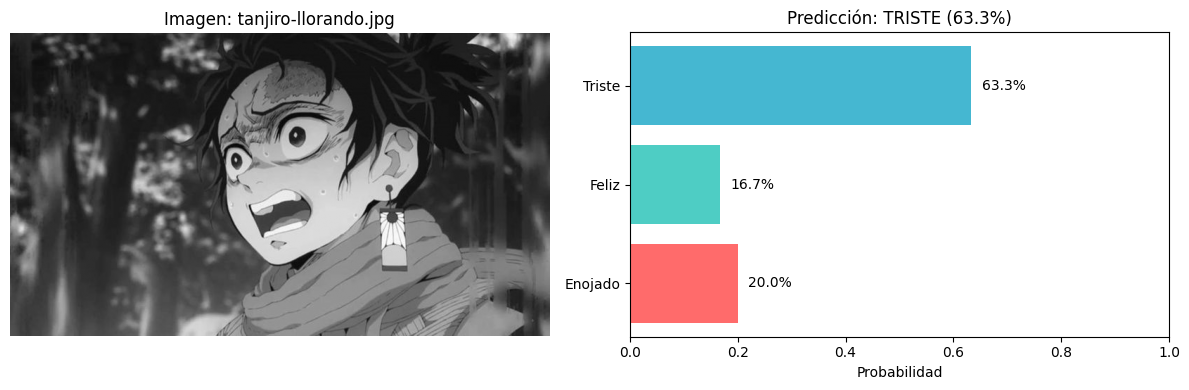


Predicción: TRISTE
Confianza: 63.30%

Detalle de probabilidades:
  Enojado       19.99% █████
  Feliz         16.70% █████
  Triste        63.30% ██████████████████


In [90]:
# Prueba con nueva imagen
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar modelo guardado
modelo = keras.models.load_model("cnn_model_emociones_v2.h5")
class_names = ['Enojado', 'Feliz', 'Triste']

#Imagen
image_path = "C:/Users/cance/Downloads/tanjiro-llorando.jpg" 
image_path = Path(image_path)

if not image_path.exists():
    print(f"No se encontró: {image_path}")
else:
    print(f"Imagen: {image_path.name}")
    
    # Convertir a JPG si es PNG u otro formato
    if image_path.suffix.lower() != '.jpg':
        print(f"  Convirtiendo {image_path.suffix} a JPG...")
        img_original = cv2.imread(str(image_path))
        jpg_path = image_path.with_suffix('.jpg')
        cv2.imwrite(str(jpg_path), img_original, [cv2.IMWRITE_JPEG_QUALITY, 95])
        image_path = jpg_path
        print(f"  Guardado como: {jpg_path.name}")
    
    # Procesar con OpenCV
    img = cv2.imread(str(image_path))  # Leer imagen
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises
    img_resized = cv2.resize(img_gray, (28, 28))  # Redimensionar a 28x28
    img_normalized = img_resized.astype('float32') / 255.0  # Normalizar [0,1]
    img_input = img_normalized.reshape(1, 28, 28, 1)  # Reshape para modelo
    
    print(f"Forma original: {img.shape}")
    print(f"Forma normalizada: {img_normalized.shape}")
    
    # Predicción con modelo guardado
    prediction = modelo.predict(img_input, verbose=0)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    
    # Visualizar
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].imshow(img_gray, cmap='gray')
    axes[0].set_title(f"Imagen: {image_path.name}")
    axes[0].axis('off')
    
    probabilities = prediction[0]
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
    axes[1].barh(class_names, probabilities, color=colors)
    axes[1].set_xlabel('Probabilidad')
    axes[1].set_title(f'Predicción: {class_names[predicted_class].upper()} ({confidence*100:.1f}%)')
    axes[1].set_xlim([0, 1])
    
    for i, (emotion, prob) in enumerate(zip(class_names, probabilities)):
        axes[1].text(prob + 0.02, i, f'{prob*100:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPredicción: {class_names[predicted_class].upper()}")
    print(f"Confianza: {confidence*100:.2f}%")
    print(f"\nDetalle de probabilidades:")
    for emotion, prob in zip(class_names, probabilities):
        barra = "█" * int(prob * 30)
        print(f"  {emotion:12} {prob*100:6.2f}% {barra}")